In [ ]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import auc, precision_recall_curve, PrecisionRecallDisplay, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression as LR
from sklearn.neural_network import MLPClassifier as MLP
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.svm import SVC
from sklearn.exceptions import ConvergenceWarning

from common import load_data

warnings.filterwarnings("ignore", category=ConvergenceWarning)


## SECTION 0:
### Useful Functions & Loading the Dataset

NOTE: "Season Fatigue" is called "CumulativeDist" in the dataset

In [12]:
# --- Useful functions to be used --- #


# creates a copy of the dataset with 'Season Fatigue' dropped or not
def gen_exp2_dataset(df, with_fatigue=False):
    new_df = df.copy()

    # one-hot encoding of categorical features
    new_df = pd.get_dummies(new_df, columns=['Position', 'StadiumType', 'FieldType', 'Weather'], dtype=int)

    if with_fatigue:
        new_df.drop(columns=['GameID', 'GameDist'], inplace=True)
    else:
        new_df.drop(columns=['GameID', 'CumulativeDist'], inplace=True)

    # make new target variable for injury occurence
    new_df['InjurySeverity'] = new_df['InjurySeverity'].apply(lambda x: 1 if x > 0 else 0)
    new_df.rename(columns={'InjurySeverity': 'Injury'}, inplace=True)

    # create dataset with more balanced classes
    injury_players_df = new_df[new_df['Injury'] > 0]['PlayerKey'].unique()
    new_df = new_df[new_df['PlayerKey'].isin(injury_players_df)]

    injury_df = new_df[new_df['Injury'] == 1]
    non_injury_df = new_df[new_df['Injury'] == 0]

    random_samples = non_injury_df.sample(n=injury_df.shape[0], random_state=42)
    new_df = pd.concat([injury_df, random_samples], axis=0)

    return new_df


# prints the stats of a dataset
def print_dataset_stats(df):
    print('Num of unique players: {}'.format(len(df['PlayerKey'].unique())))
    print('Num of injuries: {}'.format(df.shape[0]))
    print('Num of columns: {}'.format(len(df.columns)))
    print('Num of rows: {}'.format(len(df)))


# plots the precision recall curve for multiple models
def plot_prc(y_true, model_preds):
    plt.figure(figsize=(4.5, 3.5))
    for key, val in model_preds.items():
        p, r, _ = precision_recall_curve(y_true, val, pos_label=1)
        disp = PrecisionRecallDisplay(precision=p, recall=r)
        disp.plot(ax=plt.gca(), name='{} AUC = {:.3f}'.format(key, auc(r, p)))
    plt.show()


# obtains the classification report metrics for a trained model
def get_scores(y_true, y_pred):
    return classification_report(y_true, y_pred, labels=[0, 1], output_dict=True, zero_division=0)


# prints the classification report metrics for a trained model
def print_scores(scores, as_percentage=True):
    if as_percentage:
        print('Accuracy: {:.2f}%'.format(100 * scores['accuracy']))
        print('[CLASS 0] Precision: {:.2f}%, Recall: {:.2f}%, F1 Score: {:.2f}%'.format(100 * scores['0']['precision'], 100 * scores['0']['recall'], 100 * scores['0']['f1-score']))
        print('[CLASS 1] Precision: {:.2f}%, Recall: {:.2f}%, F1 Score: {:.2f}%'.format(100 * scores['1']['precision'], 100 * scores['1']['recall'], 100 * scores['1']['f1-score']))
    else:
        print('Accuracy: {:.4f}'.format(scores['accuracy']))
        print('[CLASS 0] Precision: {:.4f}, Recall: {:.4f}, F1 Score: {:.4f}'.format(scores['0']['precision'], scores['0']['recall'], scores['0']['f1-score']))
        print('[CLASS 1] Precision: {:.4f}, Recall: {:.4f}, F1 Score: {:.4f}'.format(scores['1']['precision'], scores['1']['recall'], scores['1']['f1-score']))


# prints the difference in metric scores for two models
def print_score_diff(scores1, scores2, as_percentage=True):
    if as_percentage:
        print('Accuracy Difference: {:.2f}%'.format(100 * (scores1['accuracy'] - scores2['accuracy'])))
        print('[CLASS 0] Precision Difference: {:.2f}%, Recall Difference: {:.2f}%, F1 Score Difference: {:.2f}%'.format(
            100 * (scores1['0']['precision'] - scores2['0']['precision']),
            100 * (scores1['0']['recall'] - scores2['0']['recall']),
            100 * (scores1['0']['f1-score'] - scores2['0']['f1-score'])
        ))
        print('[CLASS 1] Precision Difference: {:.2f}%, Recall Difference: {:.2f}%, F1 Score Difference: {:.2f}%'.format(
            100 * (scores1['1']['precision'] - scores2['1']['precision']),
            100 * (scores1['1']['recall'] - scores2['1']['recall']),
            100 * (scores1['1']['f1-score'] - scores2['1']['f1-score'])
        ))
    else:
        print('Accuracy Difference: {:.4f}'.format(scores1['accuracy'] - scores2['accuracy']))
        print('[CLASS 0] Precision Difference: {:.4f}, Recall Difference: {:.4f}, F1 Score Difference: {:.4f}'.format(
            scores1['0']['precision'] - scores2['0']['precision'],
            scores1['0']['recall'] - scores2['0']['recall'],
            scores1['0']['f1-score'] - scores2['0']['f1-score']
        ))
        print('[CLASS 1] Precision Difference: {:.4f}, Recall Difference: {:.4f}, F1 Score Difference: {:.4f}'.format(
            scores1['1']['precision'] - scores2['1']['precision'],
            scores1['1']['recall'] - scores2['1']['recall'],
            scores1['1']['f1-score'] - scores2['1']['f1-score']
        ))


# global variables
target_feature = 'Injury'
seed = 42


In [13]:
# --- Load the dataset and check distributions --- #
main_df = load_data('exp2_data.csv', verbose=False)

# --- Prepare datasets --- #
print('-------------- Fatigue Dataset -------------')
fatigue_df = gen_exp2_dataset(main_df, with_fatigue=True)
print_dataset_stats(fatigue_df)

print('-------------- Normal Dataset --------------')
normal_df = gen_exp2_dataset(main_df, with_fatigue=False)
print_dataset_stats(fatigue_df)
# print(normal_df.columns)


-------------- Fatigue Dataset -------------
Num of unique players: 100
Num of injuries: 210
Num of columns: 26
Num of rows: 210
-------------- Normal Dataset --------------
Num of unique players: 100
Num of injuries: 210
Num of columns: 26
Num of rows: 210


## SECTION 1:
### Evaluating Fatigue Dataset (as in "Season Fatigue")

------------ Logistic Regression ----------
Accuracy: 59.52%
[CLASS 0] Precision: 66.67%, Recall: 52.17%, F1 Score: 58.54%
[CLASS 1] Precision: 54.17%, Recall: 68.42%, F1 Score: 60.47%
-------------- Random Forest --------------
Accuracy: 66.67%
[CLASS 0] Precision: 71.43%, Recall: 65.22%, F1 Score: 68.18%
[CLASS 1] Precision: 61.90%, Recall: 68.42%, F1 Score: 65.00%
------------------- SVC -------------------
Accuracy: 57.14%
[CLASS 0] Precision: 85.71%, Recall: 26.09%, F1 Score: 40.00%
[CLASS 1] Precision: 51.43%, Recall: 94.74%, F1 Score: 66.67%
------------------- MLP -------------------
Accuracy: 57.14%
[CLASS 0] Precision: 56.10%, Recall: 100.00%, F1 Score: 71.88%
[CLASS 1] Precision: 100.00%, Recall: 5.26%, F1 Score: 10.00%


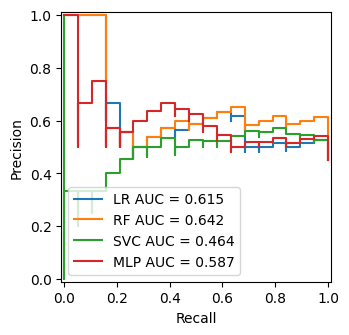

In [14]:
# --- Train and Test using Fatigue Dataset --- #
train_data, test_data = train_test_split(fatigue_df, test_size=0.2, random_state=seed, shuffle=True)

y_train = train_data[target_feature]
y_test = test_data[target_feature]
x_train = train_data.drop([target_feature], axis=1)
x_test = test_data.drop([target_feature], axis=1)

print('------------ Logistic Regression ----------')
lr = LR(random_state=seed, max_iter=1000)
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
lr_probs = lr.predict_proba(x_test)[:, 1]
lr_fatigue_scores = get_scores(y_test, y_pred)
print_scores(lr_fatigue_scores)

print('-------------- Random Forest --------------')
rfc = RFC(random_state=seed, n_estimators=1000)
rfc.fit(x_train, y_train)
y_pred = rfc.predict(x_test)
rfc_probs = rfc.predict_proba(x_test)[:, 1]
rfc_fatigue_scores = get_scores(y_test, y_pred)
print_scores(rfc_fatigue_scores)

print('------------------- SVC -------------------')
svc = SVC(random_state=seed, probability=True)
svc.fit(x_train, y_train)
y_pred = svc.predict(x_test)
svc_probs = svc.predict_proba(x_test)[:, 1]
svc_fatigue_scores = get_scores(y_test, y_pred)
print_scores(svc_fatigue_scores)

print('------------------- MLP -------------------')
mlp = MLP(hidden_layer_sizes=(64, 32, 16), max_iter=1000, random_state=seed)
mlp.fit(x_train, y_train)
y_pred = mlp.predict(x_test)
mlp_probs = mlp.predict_proba(x_test)[:, 1]
mlp_fatigue_scores = get_scores(y_test, y_pred)
print_scores(mlp_fatigue_scores)

# -------------------------- #
model_preds = {
    'LR': lr_probs,
    'RF': rfc_probs,
    'SVC': svc_probs,
    'MLP': mlp_probs
}

# --- Plot PRC for Fatigue Dataset --- #
plot_prc(y_test, model_preds)


## SECTION 2:
### Evaluating Normal Dataset (AKA default dataset without "Season Fatigue" feature)

------------ Logistic Regression ----------
Accuracy: 52.38%
[CLASS 0] Precision: 57.89%, Recall: 47.83%, F1 Score: 52.38%
[CLASS 1] Precision: 47.83%, Recall: 57.89%, F1 Score: 52.38%
-------------- Random Forest --------------
Accuracy: 47.62%
[CLASS 0] Precision: 52.00%, Recall: 56.52%, F1 Score: 54.17%
[CLASS 1] Precision: 41.18%, Recall: 36.84%, F1 Score: 38.89%
------------------- SVC -------------------
Accuracy: 45.24%
[CLASS 0] Precision: 0.00%, Recall: 0.00%, F1 Score: 0.00%
[CLASS 1] Precision: 45.24%, Recall: 100.00%, F1 Score: 62.30%
------------------- MLP -------------------
Accuracy: 50.00%
[CLASS 0] Precision: 58.33%, Recall: 30.43%, F1 Score: 40.00%
[CLASS 1] Precision: 46.67%, Recall: 73.68%, F1 Score: 57.14%


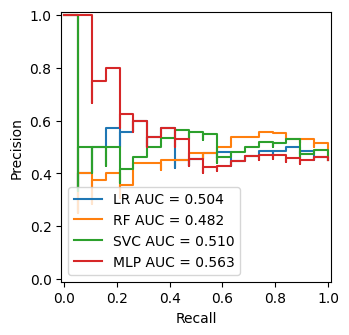

In [15]:
# --- Train and Test using Normal Dataset --- #
train_data, test_data = train_test_split(normal_df, test_size=0.2, random_state=seed, shuffle=True)

y_train = train_data[target_feature]
y_test = test_data[target_feature]
x_train = train_data.drop([target_feature], axis=1)
x_test = test_data.drop([target_feature], axis=1)

print('------------ Logistic Regression ----------')
lr = LR(random_state=seed, max_iter=1000)
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
lr_probs = lr.predict_proba(x_test)[:, 1]
lr_normal_scores = get_scores(y_test, y_pred)
print_scores(lr_normal_scores)

print('-------------- Random Forest --------------')
rfc = RFC(random_state=seed)
rfc.fit(x_train, y_train)
y_pred = rfc.predict(x_test)
rfc_probs = rfc.predict_proba(x_test)[:, 1]
rfc_normal_scores = get_scores(y_test, y_pred)
print_scores(rfc_normal_scores)

print('------------------- SVC -------------------')
svc = SVC(random_state=seed, probability=True)
svc.fit(x_train, y_train)
y_pred = svc.predict(x_test)
svc_probs = svc.predict_proba(x_test)[:, 1]
svc_normal_scores = get_scores(y_test, y_pred)
print_scores(svc_normal_scores)

print('------------------- MLP -------------------')
mlp = MLP(hidden_layer_sizes=(64, 32, 16), max_iter=1000, random_state=seed)
mlp.fit(x_train, y_train)
y_pred = mlp.predict(x_test)
mlp_probs = mlp.predict_proba(x_test)[:, 1]
mlp_normal_scores = get_scores(y_test, y_pred)
print_scores(mlp_normal_scores)

# -------------------------- #
model_preds = {
    'LR': lr_probs,
    'RF': rfc_probs,
    'SVC': svc_probs,
    'MLP': mlp_probs
}

# --- Plot PRC for Normal Dataset --- #
plot_prc(y_test, model_preds)


## SECTION 3:
### Computing Difference in Scores

In [16]:
# --- Print score differences --- #
print('------------ Logistic Regression ----------')
print_score_diff(lr_fatigue_scores, lr_normal_scores)

print('-------------- Random Forest --------------')
print_score_diff(rfc_fatigue_scores, rfc_normal_scores)

print('------------------- SVC -------------------')
print_score_diff(svc_fatigue_scores, svc_normal_scores)

print('------------------- MLP -------------------')
print_score_diff(mlp_fatigue_scores, mlp_normal_scores)


------------ Logistic Regression ----------
Accuracy Difference: 7.14%
[CLASS 0] Precision Difference: 8.77%, Recall Difference: 4.35%, F1 Score Difference: 6.16%
[CLASS 1] Precision Difference: 6.34%, Recall Difference: 10.53%, F1 Score Difference: 8.08%
-------------- Random Forest --------------
Accuracy Difference: 19.05%
[CLASS 0] Precision Difference: 19.43%, Recall Difference: 8.70%, F1 Score Difference: 14.02%
[CLASS 1] Precision Difference: 20.73%, Recall Difference: 31.58%, F1 Score Difference: 26.11%
------------------- SVC -------------------
Accuracy Difference: 11.90%
[CLASS 0] Precision Difference: 85.71%, Recall Difference: 26.09%, F1 Score Difference: 40.00%
[CLASS 1] Precision Difference: 6.19%, Recall Difference: -5.26%, F1 Score Difference: 4.37%
------------------- MLP -------------------
Accuracy Difference: 7.14%
[CLASS 0] Precision Difference: -2.24%, Recall Difference: 69.57%, F1 Score Difference: 31.87%
[CLASS 1] Precision Difference: 53.33%, Recall Difference